# Stellar Analysis of the Galactic Circumcenter

## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyvo as vo
from astropy.io import ascii
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from scipy import stats
import sklearn
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import gaussian_kde
import math

# Data Querying

## Query 1: Beam of $1 deg \times 1 deg$ towards Sagittarius A*

We have the coordinates of the Galactic center from the Literature. We use that value to create a small window of 1 x 1 centered at those coordinates, and extract all the stars, binaries and white dwarfs present in that region. This constitutes our `Beam Data`

In [2]:
query2 = '''select g.source_id, g.ra, g.ra_error, g.dec, g.dec_error, g.parallax,g.parallax_over_error,g.bp_rp,
g.pm,g.pmra,g.pmra_error,g.pmdec,g.pmdec_error,g.phot_g_mean_mag,g.phot_bp_mean_mag,g.phot_rp_mean_mag,g.radial_velocity,
h.classprob_dsc_combmod_star + h.classprob_dsc_combmod_whitedwarf + h.classprob_dsc_combmod_binarystar as comb
from gaiadr3.gaia_source as g, gaiadr
3.astrophysical_parameters as h 
where g.source_id = h.source_id and
g.ra between 265.9157 and 266.9157 and
g.dec between -29.50728 and -28.50728
order by g.phot_g_mean_mag desc, comb desc'''


job = Gaia.launch_job_async(query2)
r2 = job.get_results()

print('\nTotal number of stars queried: ',len(r2))

500 Error 500:
null


HTTPError: Error 500:
null

Subsequently a `CSV` file was created containing the data set for easy access. This is named `r2`.

In [3]:
#Uncomment the following lines to make the dataset
#df_r2 = r2.to_pandas()
#df_r2.to_csv('./data/BeamData.csv')

r2 = pd.read_csv('./data/BeamData.csv')

#Application of Parallax Outlier Cutoff

q_low = r2["parallax"].quantile(0.162)
r2 = r2[(r2["parallax"] > q_low)]
r2 = r2.loc[r2['parallax_over_error']<15]

## Query 2: Sphere of Radius 300 Parsecs around the Galactic Center

For the sphere data, we assumed that the radius of our interest is about 300 parsecs. Since the galactic center is about 8 kiloparsecs from earth, an extension of `r_s` pasecs from the galactic plane must make an angle of about, $$\theta = \arctan{(\frac{r_s}{8000})}$$
This angle $\theta$ is half the window width that we need. Hence the width of the window that we must extract should be about $2\times\theta$. Also, all the stars that are $r_s$ away and towards the earth must subtend different parallex angles. Hence the parallax limit was added to make this apparent 2D selection, 3D.

In [ ]:
#Coordinates of the Galactic Center
c = SkyCoord('17h45m40.04s', '-29d00m28.1s', frame='icrs')

#RA and DECof the Galactic Center
c_ra = 266.41683333
c_dec = -29.00780556

#Radius of Selection in Parsecs
r_s = 300
width = np.degrees(np.arctan(r_s / 8000))
print('The required width of window is: ', round(2 * width, 3), "degrees")

a1 = round(c_ra + width,3)
a2 = round(c_ra - width,3)
b1 = round(c_dec + width,3)
b2 = round(c_dec - width,3)
print(f'\nThe required RA values are: {a2} and {a1}')
print(f'The required DEC values are: {b2} and {b1}')

c1 = round(1000/(8000+r_s),4)
c2 = round(1000/(8000-r_s),4)
print(f'\nThe required parallax window is: {c1} and {c2}')

query = f'''select g.source_id, g.ra, g.ra_error, g.dec, g.dec_error, g.parallax,g.parallax_over_error,g.bp_rp,
g.pm,g.pmra,g.pmra_error,g.pmdec,g.pmdec_error,g.phot_g_mean_mag,g.phot_bp_mean_mag,g.phot_rp_mean_mag,g.radial_velocity,
h.classprob_dsc_combmod_star + h.classprob_dsc_combmod_whitedwarf + h.classprob_dsc_combmod_binarystar as comb
from gaiadr3.gaia_source as g, gaiadr3.astrophysical_parameters as h 
where g.source_id = h.source_id and
g.ra between {a2} and {a1} and
g.dec between {b2} and {b1} and
g.parallax between {c1} and {c2}
order by g.phot_g_mean_mag desc, comb desc'''


job = Gaia.launch_job_async(query)
r = job.get_results()

print('\nTotal number of stars queried: ',len(r))

Similarly this query was added into a dataset named `r`.

In [4]:
#df_r = r.to_pandas()
#df_r.to_csv('./data/ShpereData.csv')
r = pd.read_csv('./data/ShpereData.csv')

# Dataset Visualization

## RA and DEC Distribution

### Beam Data

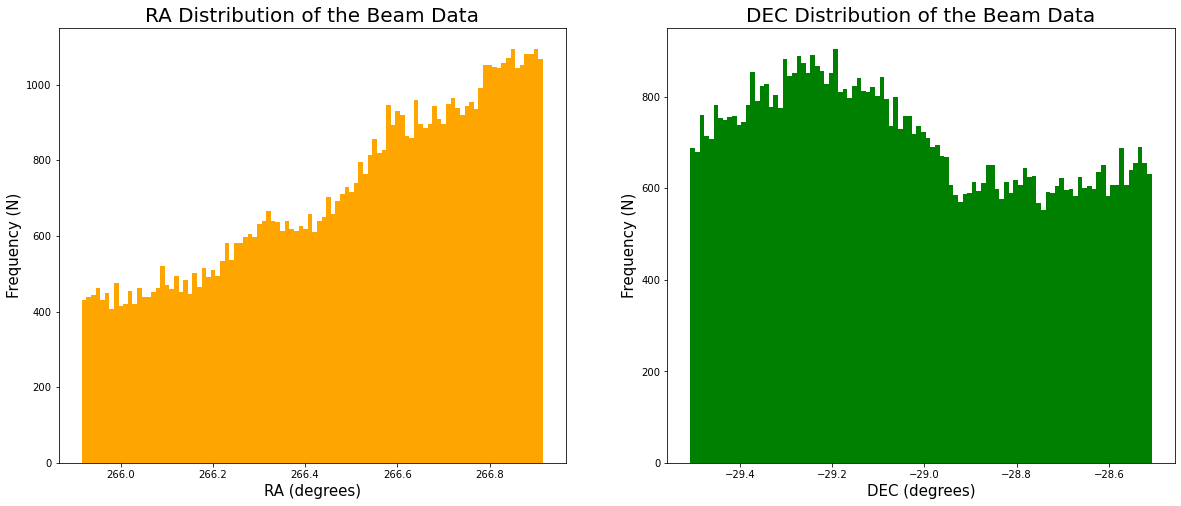

In [40]:
plt.figure(figsize=(20, 8))

#Plotting the RA Distribution
plt.subplot(1, 2, 1)
plt.hist(r2['ra'], bins=100, histtype='stepfilled', color='orange')
plt.title('RA Distribution of the Beam Data', size=20)
plt.xlabel('RA (degrees)', size=15)
plt.ylabel('Frequency (N)', size=15)

#Plotting the DEC Distribution
plt.subplot(1, 2, 2)
plt.hist(r2['dec'], bins=100, histtype='stepfilled', color='green')
plt.title('DEC Distribution of the Beam Data', size=20)
plt.xlabel('DEC (degrees)', size=15)
plt.ylabel('Frequency (N)', size=15)
plt.show()

### Sphere Data

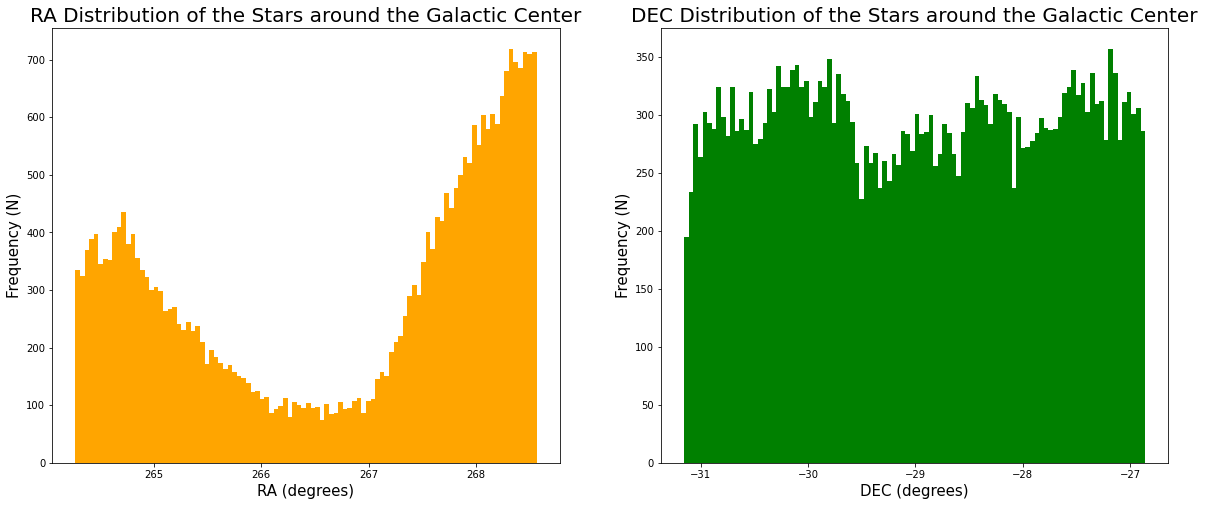

In [41]:
plt.figure(figsize=(20, 8))

#Plotting the RA Distribution
plt.subplot(1, 2, 1)
plt.hist(r['ra'], bins=100, histtype='stepfilled', color='orange')
plt.title('RA Distribution of the Stars around the Galactic Center', size=20)
plt.xlabel('RA (degrees)', size=15)
plt.ylabel('Frequency (N)', size=15)

#Plotting the DEC Distribution
plt.subplot(1, 2, 2)
plt.hist(r['dec'], bins=100, histtype='stepfilled', color='green')
plt.title('DEC Distribution of the Stars around the Galactic Center', size=20)
plt.xlabel('DEC (degrees)', size=15)
plt.ylabel('Frequency (N)', size=15)
plt.show()

## Distance Distribution

The distance to a distant star is defined using the parallax as: ![Parallax](./images/parallax.png). We can use the tangent of the parallax to find the distance to the star as $$\tan p = \frac{1AU}{P}$$. Since the star is very far, the tangent of the angle is approximately equal to the angle itself, hence the final formula is $$d = \frac{1000}{p}$$
Where, $p$ is in milliarcseconds.

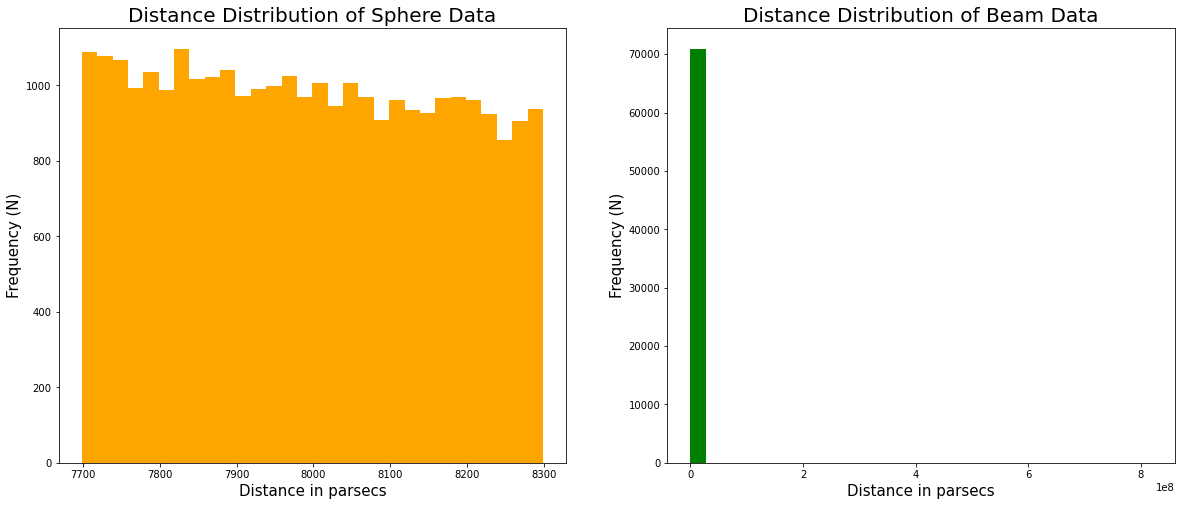

In [42]:
dist_r = 1000 * abs(np.reciprocal(r['parallax']))
dist_r2 = 1000 * abs(np.reciprocal(r2['parallax']))

plt.figure(figsize=(20,8))

#Plotting the RA Distribution
plt.subplot(1, 2, 1)
plt.hist(dist_r, bins=30, histtype='stepfilled', color='orange')
plt.title('Distance Distribution of Sphere Data',size=20)
plt.xlabel('Distance in parsecs',size=15)
plt.ylabel('Frequency (N)',size=15)

#Plotting the DEC Distribution
plt.subplot(1, 2, 2)
plt.hist(dist_r2, bins=30, histtype='stepfilled', color='green')
plt.title('Distance Distribution of Beam Data',size=20)
plt.xlabel('Distance in parsecs',size=15)
plt.ylabel('Frequency (N)',size=15)
plt.show()

## Proper Motion Distribution

### Total Proper Motion Distribution 

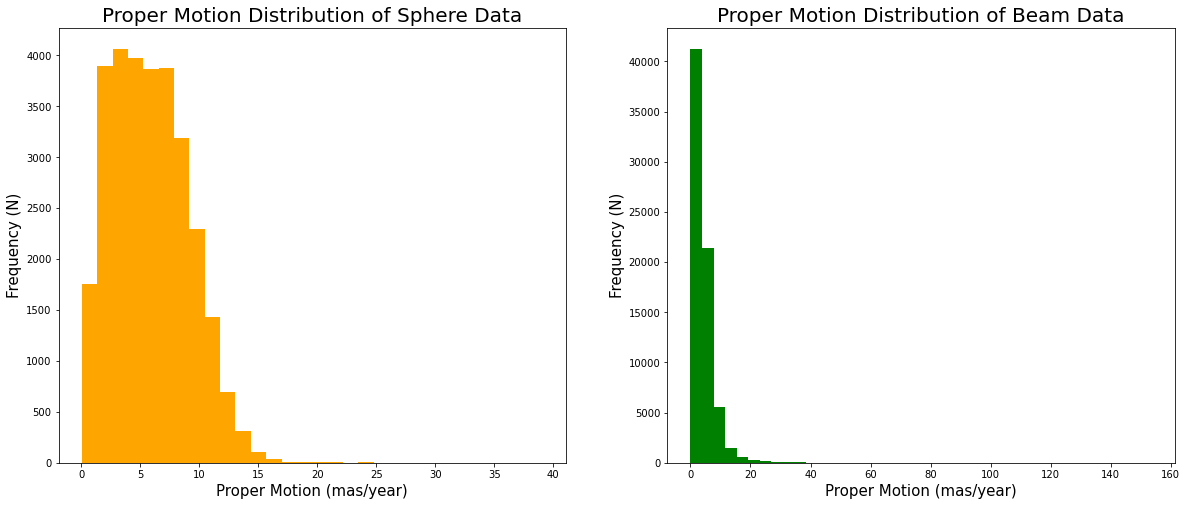

In [43]:
plt.figure(figsize=(20, 8))

#Plotting the RA Distribution
plt.subplot(1, 2, 1)
plt.hist(r['pm'], bins=30, histtype='stepfilled', color='orange')
plt.title('Proper Motion Distribution of Sphere Data', size=20)
plt.xlabel('Proper Motion (mas/year)', size=15)
plt.ylabel('Frequency (N)', size=15)

#Plotting the DEC Distribution
plt.subplot(1, 2, 2)
plt.hist(r2['pm'], bins=40, histtype='stepfilled', color='green')
plt.title('Proper Motion Distribution of Beam Data', size=20)
plt.xlabel('Proper Motion (mas/year)', size=15)
plt.ylabel('Frequency (N)', size=15)
plt.show()

### Density Scatter Plots of Proper Motion of RA and DEC for Beam and Sphere Data

In [ ]:
x = r['pmra']; x1 = r2['pmra'] 
y = r['pmdec']; y1 = r2['pmdec']

# Calculate the point density
xy = np.vstack([x, y])
xy1 = np.vstack([x1, y1])
z = gaussian_kde(xy)(xy)
z1 = gaussian_kde(xy1)(xy1)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=z, s=10, cmap='viridis')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Proper Motion in RA (mas/year)', size=10)
plt.ylabel('Proper Motion in DEC (mas/year)', size=10)
plt.title('Density Scatter Plot of Proper Motion in RA and DEC (Sphere Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)


plt.subplot(1, 2, 2)
plt.scatter(x1, y1, c=z1, s=10, cmap='magma')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Proper Motion in RA (mas/year)', size=10)
plt.ylabel('Proper Motion in DEC (mas/year)', size=10)
plt.title('Density Scatter Plot of Proper Motion in RA and DEC (Beam Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)
plt.figtext(0.42, 0.73, 'Density', size=10)
plt.figtext(0.84, 0.73, 'Density', size=10)
plt.show()

## Apparent Magnitude Distribution

In [ ]:
plt.figure(figsize=(20,8))

#Plotting the RA Distribution
plt.subplot(1, 2, 1)
plt.hist(r['phot_g_mean_mag'], bins=30, histtype='stepfilled', color='orange')
plt.title('Apparent Magnitude Distribution of Sphere Data',size=20)
plt.xlabel('Apparent Magnitude (mag)',size=15)
plt.ylabel('Frequency (N)',size=15)

#Plotting the DEC Distribution
plt.subplot(1, 2, 2)
plt.hist(r2['phot_g_mean_mag'], bins=30, histtype='stepfilled', color='green')
plt.title('Apparent Magnitude Distribution of Beam Data',size=20)
plt.xlabel('Apparent Magnitude (mag)',size=15)
plt.ylabel('Frequency (N)',size=15)
plt.show()

## Sky Plot

In [ ]:
r = r.dropna(subset = ['phot_g_mean_mag'])
r2 = r2.dropna(subset = ['phot_g_mean_mag'])
dist_r = 1000 * abs(np.reciprocal(r['parallax']))
dist_r2 = 1000 * abs(np.reciprocal(r2['parallax']))

In [ ]:
x = r['phot_g_mean_mag']; x1 = r2['phot_g_mean_mag'] 
y = dist_r; y1 = dist_r2

# Calculate the point density
xy = np.vstack([x, y])
xy1 = np.vstack([x1, y1])
z = gaussian_kde(xy)(xy)
z1 = gaussian_kde(xy1)(xy1)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=z, s=10, cmap='viridis')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Apparent Magnitude', size=10)
plt.ylabel('Distance in Parsecs', size=10)
plt.title('Density Scatter Plot of Apparent Magnitude and Distance (Sphere Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)


plt.subplot(1, 2, 2)
plt.scatter(x1, y1, c=z1, s=10, cmap='magma')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Apparent Magnitude', size=10)
plt.ylabel('Distance in Parsecs', size=10)
plt.title('Density Scatter Plot of Apparent Magnitude and Distance (Beam Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)
plt.figtext(0.42, 0.73, 'Density', size=10)
plt.figtext(0.84, 0.73, 'Density', size=10)
plt.show()

## Distance and Proper Motion Plot

In [ ]:
r = pd.read_csv('./data/ShpereData.csv')
r2 = pd.read_csv('./data/BeamData.csv')

#Application of Parallax Outlier Cutoff

q_low = r2["parallax"].quantile(0.162)
r2 = r2[(r2["parallax"] > q_low)]
r2 = r2.loc[r2['parallax_over_error']<15]

In [ ]:
r = r.dropna(subset = ['pm'])
r2 = r2.dropna(subset = ['pm'])
dist_r = 1000 * abs(np.reciprocal(r['parallax']))
dist_r2 = 1000 * abs(np.reciprocal(r2['parallax']))

In [ ]:
y = r['pm']; y1 = r2['pm'] 
x = dist_r; x1 = dist_r2

# Calculate the point density
xy = np.vstack([x, y])
xy1 = np.vstack([x1, y1])
z = gaussian_kde(xy)(xy)
z1 = gaussian_kde(xy1)(xy1)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=z, s=10, cmap='viridis')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Proper Motion (mas/year)', size=10)
plt.xlabel('Distance in Parsecs', size=10)
plt.title('Density Scatter Plot of Apparent Magnitude and Distance (Sphere Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)


plt.subplot(1, 2, 2)
plt.scatter(x1, y1, c=z1, s=10, cmap='magma')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Proper Motion (mas/year)', size=10)
plt.xlabel('Distance in Parsecs', size=10)
plt.title('Density Scatter Plot of Apparent Magnitude and Distance (Beam Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)
plt.figtext(0.42, 0.73, 'Density', size=10)
plt.figtext(0.84, 0.73, 'Density', size=10)
plt.show()

## Proper Motion and Apparent Magnitude

In [9]:
r = pd.read_csv('./data/ShpereData.csv')
r = r.loc[r['parallax_over_error']<20]
r2 = pd.read_csv('./data/BeamData.csv')

#Application of Parallax Outlier Cutoff

q_low = r2["parallax"].quantile(0.162)
r2 = r2[(r2["parallax"] > q_low)]
r2 = r2.loc[r2['parallax_over_error']<20]

In [10]:
r = r.dropna(subset = ['pm'])
r2 = r2.dropna(subset = ['pm'])

In [11]:
r = r.dropna(subset = ['phot_g_mean_mag'])
r2 = r2.dropna(subset = ['phot_g_mean_mag'])

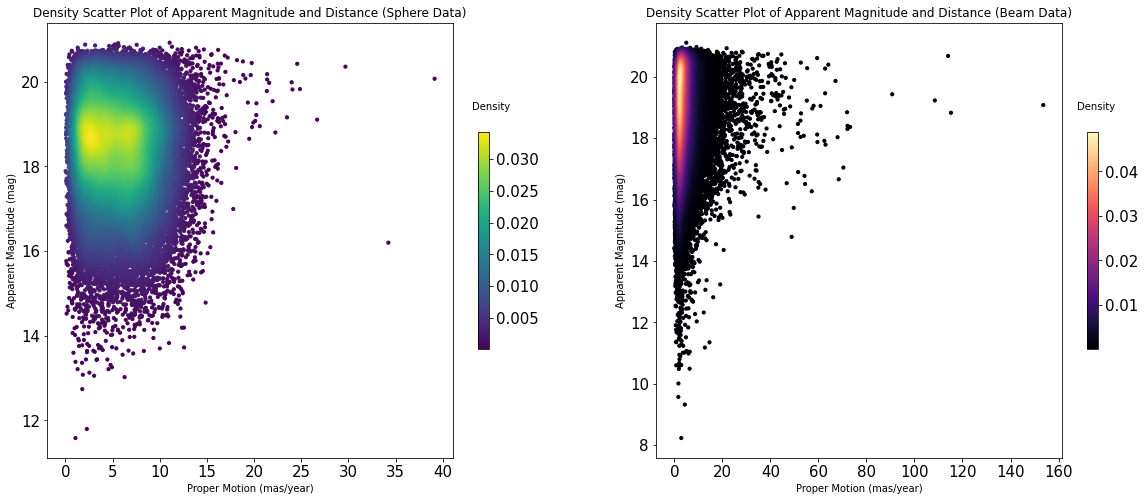

In [12]:
x = r['pm']; x1 = r2['pm'] 
y = r['phot_g_mean_mag']; y1 = r2['phot_g_mean_mag']

# Calculate the point density
xy = np.vstack([x, y])
xy1 = np.vstack([x1, y1])
z = gaussian_kde(xy)(xy)
z1 = gaussian_kde(xy1)(xy1)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=z, s=10, cmap='viridis')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Apparent Magnitude (mag)', size=10)
plt.xlabel('Proper Motion (mas/year)', size=10)
plt.title('Density Scatter Plot of Apparent Magnitude and Distance (Sphere Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)


plt.subplot(1, 2, 2)
plt.scatter(x1, y1, c=z1, s=10, cmap='magma')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Apparent Magnitude (mag)', size=10)
plt.xlabel('Proper Motion (mas/year)', size=10)
plt.title('Density Scatter Plot of Apparent Magnitude and Distance (Beam Data)')
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)
plt.figtext(0.42, 0.73, 'Density', size=10)
plt.figtext(0.84, 0.73, 'Density', size=10)
plt.show()

## Color Magnitde Diagram

In [5]:
r = pd.read_csv('./data/ShpereData.csv')
r = r.loc[r['parallax_over_error']<20]
#q_low = r["parallax"].quantile(0.162)
#r = r[(r["parallax"] > q_low)]

r2 = pd.read_csv('./data/BeamData.csv')
r2 = r2.loc[r2['parallax_over_error']<20]
#q_low = r2["parallax"].quantile(0.162)
#r2 = r2[(r2["parallax"] > q_low)]


r = r[r['phot_g_mean_mag'].notna()]
r2 = r2[r2['phot_g_mean_mag'].notna()]


r = r[r['parallax'].notna()]
r2 = r2[r2['parallax'].notna()]

r = r[r['phot_bp_mean_mag'].notna()]
r2 = r2[r2['phot_bp_mean_mag'].notna()]

r = r[r['phot_rp_mean_mag'].notna()]
r2 = r2[r2['phot_rp_mean_mag'].notna()]

In [6]:
dist_r = 1000 * abs(np.reciprocal(r['parallax']))
dist_r2 = 1000 * abs(np.reciprocal(r2['parallax']))

In [7]:
abmags_r = r['phot_g_mean_mag'] + 5 - (5*np.log10(dist_r))
g = r['phot_bp_mean_mag'] - r['phot_rp_mean_mag']

abmags_r2 = r2['phot_g_mean_mag'] + 5 - 5*np.log10(dist_r2)
g2 = r2['phot_bp_mean_mag'] - r2['phot_rp_mean_mag']

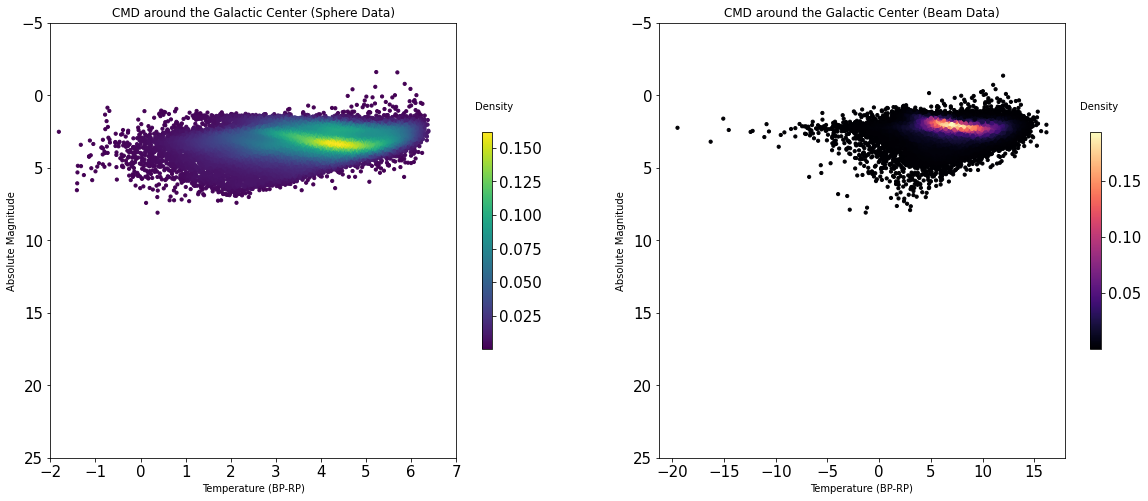

In [8]:
x = abmags_r; x1 = abmags_r2
y = g; y1 = g2

# Calculate the point density
xy = np.vstack([x, y])
xy1 = np.vstack([x1, y1])
z = gaussian_kde(xy)(xy)
z1 = gaussian_kde(xy1)(xy1)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=z, s=10, cmap='viridis')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.gca().invert_yaxis()
plt.xlabel('Temperature (BP-RP)')
plt.ylabel('Absolute Magnitude')
plt.title('CMD around the Galactic Center (Sphere Data)')
plt.xlim(-2,7)
plt.ylim(25,-5)

cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)


plt.subplot(1, 2, 2)
plt.scatter(x1, y1, c=z1, s=10, cmap='magma')
plt.tick_params(labelsize=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.gca().invert_yaxis()
plt.xlabel('Temperature (BP-RP)')
plt.ylabel('Absolute Magnitude')
plt.title('CMD around the Galactic Center (Beam Data)')
#plt.xlim(-2,7)
plt.ylim(25,-5)
cb = plt.colorbar(shrink=0.5)
cb.ax.tick_params(labelsize=15)

plt.figtext(0.42, 0.73, 'Density', size=10)
plt.figtext(0.84, 0.73, 'Density', size=10)
plt.show()

## Radial Velocity Distribution

In [9]:
r = pd.read_csv('./data/ShpereData.csv')
r = r.loc[r['parallax_over_error']<20]

q_low = r["parallax"].quantile(0.162)
r = r[(r["parallax"] > q_low)]

r2 = pd.read_csv('./data/BeamData.csv')
r2 = r2.loc[r2['parallax_over_error']<20]

q_low = r2["parallax"].quantile(0.162)
r2 = r2[(r2["parallax"] > q_low)]

r = r[r['parallax'].notna()]
r2 = r2[r2['parallax'].notna()]

r = r[r['radial_velocity'].notna()]
r2 = r2[r2['radial_velocity'].notna()]

In [10]:
dist_r = 1000 * abs(np.reciprocal(r['parallax']))
dist_r2 = 1000 * abs(np.reciprocal(r2['parallax']))

In [11]:
r['Distance'] = dist_r
r2['Distance'] = dist_r2

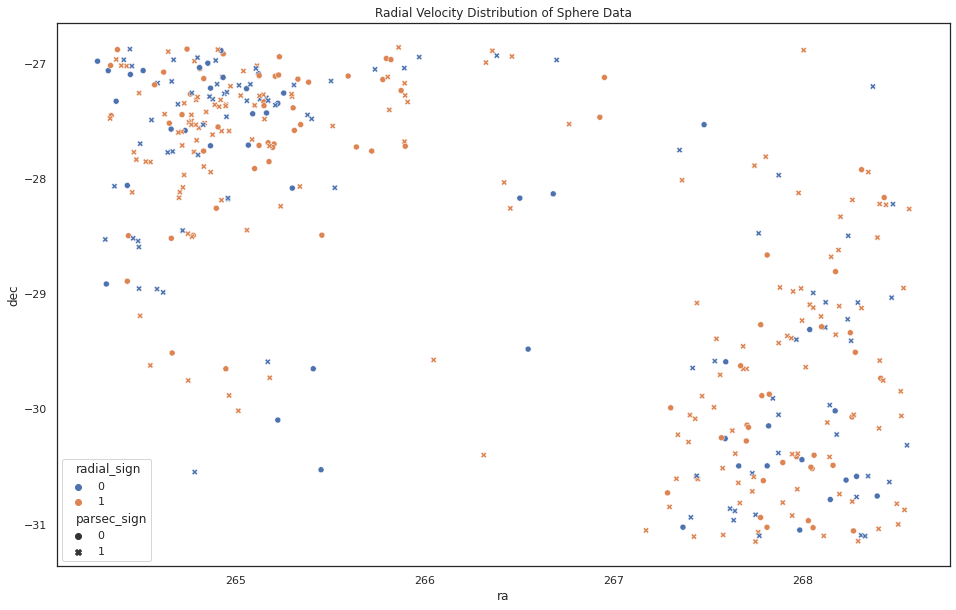

In [14]:
sns.scatterplot(data=r,
                x='ra',
                y='dec',
                hue='radial_sign',
                style='parsec_sign').set(
                    title='Radial Velocity Distribution of Sphere Data')
sns.set(rc={'figure.figsize': (16, 10)})
sns.set_style('whitegrid')
sns.set_theme(style='white')